# Importing the required libraries

In [90]:
from kiteconnect import KiteConnect,KiteTicker
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import os 
import time
from time import sleep 
import statsmodels.api as sm
from pyotp import TOTP
from datetime import datetime
from urllib.parse import urlparse,parse_qs
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from backtesting import Strategy,Backtest
from backtesting.lib import crossover
import ta
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Automate user-login to kite-connect via selenium

In [2]:
def get_curr_path(folder_name):
    curr_dir = os.getcwd()
    curr_path = os.path.join(curr_dir,folder_name)
    return curr_path

def get_credentials(curr_path,file_name):
    file_dir = os.path.join(curr_path,file_name)
    file = open(file_dir,'r').read().split()
    api_key = file[0]
    api_secret = file[1]
    user_name = file[2]
    pwd = file[3]
    totp_key = file[-1]
    return api_key,api_secret,user_name,pwd,totp_key

def auto_login(api_key,user_name,pwd,totp_key):
    kite = KiteConnect(api_key=api_key)
    service = Service(ChromeDriverManager().install())
    service.start()
    options = Options()
    options.to_capabilities()
    driver = webdriver.Remote(
        command_executor=service.service_url,
        options=options)
    driver.get(kite.login_url())
    driver.implicitly_wait(5)
    username = driver.find_element(By.XPATH, "//input[@type='text']")
    username.send_keys(user_name)
    password = driver.find_element(By.XPATH, "//input[@type='password']")
    password.send_keys(pwd)
    driver.find_element(By.XPATH, "//button[@type='submit']").click()
    sleep(1)
    totp = driver.find_element(By.XPATH,"//input[@type='number']")
    totp_token = TOTP(totp_key)
    token = totp_token.now()
    totp.send_keys(token)
    driver.find_element(By.XPATH,"//button[@type = 'submit']").click()
    sleep(1)
    current_url = driver.current_url
    parsed_url = urlparse(current_url)
    query_params = parse_qs(parsed_url.query)
    request_token = query_params.get('request_token',[None])[0]
    with open('request_token.txt', 'w') as f:
        f.write(request_token)
    request_token = open('request_token.txt','r').read()
    driver.quit()
    return request_token
    

def generate_access_token(request_token,api_key,api_secret):
    request_token = open('request_token.txt','r').read()
    kite = KiteConnect(api_key=api_key)
    data = kite.generate_session(request_token=request_token,api_secret=api_secret)
    data
    with open('access_token.txt','w') as f:
        f.write(data['access_token'])
    access_token = open('access_token.txt','r').read()
    return access_token

In [3]:
folder_name = 'api_keys'
curr_dir = get_curr_path(folder_name)

file_name = 'credentials.txt'
api_key,api_secret,user_name,pwd,totp_key = get_credentials(curr_dir,file_name)

request_token = auto_login(api_key,user_name,pwd,totp_key)

access_token = generate_access_token(request_token,api_key,api_secret)

# Setting up the access token to execute buy,sell orders

In [4]:
kite = KiteConnect(api_key=api_key)
kite.set_access_token(access_token=access_token)

In [5]:
instrument_dump = kite.instruments('NSE')
instrument_df = pd.DataFrame(instrument_dump)
instrument_df.to_csv('NSE_instruments.csv',index=False)

In [6]:
def tokenLookup(instrument_df,symbol_list):
    """Looks up instrument token for a given script from instrument dump"""
    token_list = []
    for symbol in symbol_list:
        token_list.append(int(instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]))
    return token_list

def tickerLookup(token):
    global instrument_df
    return instrument_df[instrument_df.instrument_token==token].tradingsymbol.values[0] 

def instrumentLookup(instrument_df,symbol):
    """Looks up instrument token for a given script from instrument dump"""
    try:
        return instrument_df[instrument_df.tradingsymbol==symbol].instrument_token.values[0]
    except:
        return -1

def fetchOHLC(ticker,interval,duration):
    """extracts historical data and outputs in the form of dataframe"""
    instrument = instrumentLookup(instrument_df,ticker)
    data = pd.DataFrame(kite.historical_data(instrument,dt.date.today()-dt.timedelta(duration), dt.date.today(),interval))
    data.set_index("date",inplace=True)
    return data

def fetchOHLCExtended(ticker, inception_date, interval):
    """Extracts historical data and outputs in the form of a DataFrame.
       inception_date string format - dd-mm-yyyy"""
    instrument = instrumentLookup(instrument_df, ticker)
    from_date = dt.datetime.strptime(inception_date, '%d-%m-%Y')
    data = pd.DataFrame()  # Start with an empty DataFrame
    while True:
        if from_date.date() >= (dt.date.today() - dt.timedelta(100)):
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, dt.date.today(), interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            break
        else:
            to_date = from_date + dt.timedelta(100)
            new_data = pd.DataFrame(kite.historical_data(instrument, from_date, to_date, interval))
            if not new_data.empty:
                if data.empty:
                    data = new_data
                else:
                    data = pd.concat([data, new_data], ignore_index=True)
            from_date = to_date
    
    if not data.empty:
        data.set_index("date", inplace=True)
    return data

# Extracting 5 minute interval data of infosys stock

In [7]:
ohlc = fetchOHLCExtended("INFY", "01-01-2023", '5minute')

In [8]:
ohlc.shape

(26979, 5)

In [9]:
ohlc.head()

,open,high,low,close,volume
date,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.6,112529
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.5,65472
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.9,46039
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.1,82424
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.4,93748


# Computing the technical indicators 

<h3>Computing Exponential Moving Average</h3>
<ol>
    <li>There are three steps to calculate the EMA:</li>
    <li>Calculate the Simple Moving Average (SMA)</li>
    <li>Compute Multiplier = (2 / (n + 1))</li>
    <li>For the first EMA, use the SMA of the previous day. For subsequent EMAs, use:
        <br>EMA = {Close - EMA(previous day)} x Multiplier + EMA(previous day)
    </li>
</ol>

<h3>Procedure to Compute MACD</h3>
<ol>
    <li>MACD Line: (12-day EMA - 26-day EMA)</li>
    <li>Signal Line: 9-day EMA of the MACD Line</li>
    <li>MACD Histogram: MACD Line - Signal Line</li>
</ol>


In [10]:
temp_df = ohlc.copy()
temp_df.head()

,open,high,low,close,volume
date,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.6,112529
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.5,65472
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.9,46039
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.1,82424
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.4,93748


In [11]:
temp_df.to_csv('dummy.csv') 

In [12]:
temp_df.shape

(26979, 5)

In [13]:
def compute_ema(df,n,column_name):
    df = df.copy()
    df[column_name] = np.nan
    df.loc[df.index[n-1], column_name] = df['close'][:n].mean()
    multiplier = 2 / (n + 1)
    for i in range(n,len(df)):
        df.loc[df.index[i],column_name] = (df.loc[df.index[i],'close'] - df.loc[df.index[i - 1],column_name]) * multiplier + df.loc[df.index[i - 1],column_name]
    return df

In [14]:
temp_df = compute_ema(temp_df,12,'fast_ma')
temp_df = compute_ema(temp_df,26,'slow_ma')
temp_df['macd'] = temp_df['fast_ma'] - temp_df['slow_ma']

In [15]:
temp_df 

,open,high,low,close,volume,fast_ma,slow_ma,macd
date,,,,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.60,112529,NaN,NaN,NaN
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.50,65472,NaN,NaN,NaN
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.90,46039,NaN,NaN,NaN
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.10,82424,NaN,NaN,NaN
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.40,93748,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564


In [16]:
def compute_signal(df, n):
    df = df.copy()
    df['signal'] = np.nan
    
    first_valid_index = df['macd'].first_valid_index()
    if first_valid_index is None:
        raise ValueError("MACD column contains only NaN values.")
    
    start_index = df.index.get_loc(first_valid_index) + n - 1
    if start_index < len(df):
        df.loc[df.index[start_index], 'signal'] = df['macd'].iloc[start_index - n + 1:start_index + 1].mean()
    multiplier = 2 / (n + 1)
    for i in range(start_index + 1, len(df)):
        df.loc[df.index[i], 'signal'] = ((df.loc[df.index[i], 'macd'] - df.loc[df.index[i - 1], 'signal']) 
                                          * multiplier) + df.loc[df.index[i - 1], 'signal']   
    return df

In [17]:
temp_df = compute_signal(temp_df,9)
temp_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal
date,,,,,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.60,112529,NaN,NaN,NaN,NaN
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.50,65472,NaN,NaN,NaN,NaN
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.90,46039,NaN,NaN,NaN,NaN
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.10,82424,NaN,NaN,NaN,NaN
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.40,93748,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378


In [18]:
temp_df['macd_histogram'] = temp_df['macd'] - temp_df['signal']
temp_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal,macd_histogram
date,,,,,,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.60,112529,NaN,NaN,NaN,NaN,NaN
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.50,65472,NaN,NaN,NaN,NaN,NaN
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.90,46039,NaN,NaN,NaN,NaN,NaN
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.10,82424,NaN,NaN,NaN,NaN,NaN
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.40,93748,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185


In [19]:
temp_df.to_csv('macd.csv')

<h3>Procedure for calculating the rsi</h3>
<ol>
  <li><b>Formula for RSI</b>:
    <br>RSI = 100 - 100 / (1 + RS)
  </li>
  <li><b>Calculation of RS (Relative Strength)</b>:
    <br>RS = Average Gain of n days UP / Average Loss of n days DOWN
  </li>
  <li><b>Determine Change</b>:
    <br>change = change(close)
  </li>
  <li><b>Calculate Gain</b>:
    <br>gain = change >= 0 ? change : 0.0
  </li>
  <li><b>Calculate Loss</b>:
    <br>loss = change < 0 ? (-1) * change : 0.0
  </li>
  <li><b>Compute Average Gain</b>:
    <br>avgGain = rma(gain, 14)
    <br>- rma denotes the running moving average.
  </li>
  <li><b>Compute Average Loss</b>:
    <br>avgLoss = rma(loss, 14)
  </li>
  <li><b>Calculate RS</b>:
    <br>rs = avgGain / avgLoss
  </li>
  <li><b>Calculate RSI</b>:
    <br>rsi = 100 - (100 / (1 + rs))
  </li>
  <li><b>RSI Equivalence</b>:
    <br>The calculated RSI value, as shown above, is exactly equal to:
    <br>rsi(close, 14)
  </li>
</ol>


In [20]:
def compute_rsi(df,n):
    df = df.copy()
    df['close_diff'] = df['close'].diff().dropna()
    # df.dropna(inplace=True)
    df['gain'] = df['close_diff'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['close_diff'].apply(lambda x: -x if x < 0 else 0)
    alpha = 1/n
    
    for i in range(n,len(df)):
        if i == n:
            df.loc[df.index[i],'avg_gain'] = df['gain'].rolling(window=n,min_periods=n).mean().iloc[n-1]
            df.loc[df.index[i],'avg_loss'] = df['loss'].rolling(window=n,min_periods=n).mean().iloc[n-1]
        else:
            df.loc[df.index[i],'avg_gain'] = (alpha * df.loc[df.index[i],'gain']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_gain'])
            df.loc[df.index[i],'avg_loss'] = (alpha * df.loc[df.index[i],'loss']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_loss'])
    
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100/(1 + df['rs']))
    return df

In [21]:
copy_df = temp_df.copy()

In [22]:
copy_df = compute_rsi(copy_df,14)

In [23]:
copy_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,rsi
date,,,,,,,,,,,,,,,,,
2023-01-02 09:15:00+05:30,1514.00,1514.75,1508.30,1508.60,112529,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2023-01-02 09:20:00+05:30,1509.15,1511.80,1506.20,1511.50,65472,NaN,NaN,NaN,NaN,NaN,2.90,2.90,0.00,NaN,NaN,NaN,NaN
2023-01-02 09:25:00+05:30,1511.50,1511.95,1506.50,1507.90,46039,NaN,NaN,NaN,NaN,NaN,-3.60,0.00,3.60,NaN,NaN,NaN,NaN
2023-01-02 09:30:00+05:30,1507.90,1508.35,1504.15,1507.10,82424,NaN,NaN,NaN,NaN,NaN,-0.80,0.00,0.80,NaN,NaN,NaN,NaN
2023-01-02 09:35:00+05:30,1506.65,1509.45,1506.00,1509.40,93748,NaN,NaN,NaN,NaN,NaN,2.30,2.30,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608,-0.20,0.00,0.20,0.547796,0.387089,1.415167,58.594998
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202,-0.40,0.00,0.40,0.508668,0.388012,1.310961,56.727951
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185,0.05,0.05,0.00,0.475906,0.360296,1.320873,56.912767


In [24]:
# copy_df.isna().sum()

In [25]:
copy_df.dropna(inplace=True)

In [26]:
# len(copy_df)

In [27]:
copy_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,rsi
date,,,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,1513.933687,1513.165483,0.768204,0.722998,0.045206,0.70,0.70,0.00,0.629001,0.415089,1.515340,60.243941
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,1514.128505,1513.316188,0.812316,0.740862,0.071455,0.50,0.50,0.00,0.619787,0.385440,1.607998,61.656418
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,1514.270273,1513.444619,0.825654,0.757820,0.067834,-0.15,0.00,0.15,0.575516,0.368623,1.561261,60.956728
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,1514.674846,1513.700573,0.974274,0.801111,0.173163,1.85,1.85,0.00,0.666551,0.342293,1.947313,66.070792
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1515.032562,1513.944975,1.087588,0.858406,0.229181,0.10,0.10,0.00,0.626083,0.317843,1.969786,66.327541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608,-0.20,0.00,0.20,0.547796,0.387089,1.415167,58.594998
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202,-0.40,0.00,0.40,0.508668,0.388012,1.310961,56.727951
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185,0.05,0.05,0.00,0.475906,0.360296,1.320873,56.912767


# Target profit and stop loss 

In [28]:
def compute_targets(df,risk,reward):
    close_price = df['close'].iloc[-1]
    stop_loss = close_price - risk 
    take_profit = close_price + reward 
    return stop_loss,take_profit

In [29]:
sl,tp = compute_targets(copy_df,2,4)
print(sl,tp)

1508.25 1514.25


In [30]:
backtest_df = copy_df.copy()

# Backtesting with backtesting.py

<h4>Note this only works with small datasets (30 day range)</h4>

In [31]:
backtest_df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume',
    'macd':'MACD',
    'signal': 'MACD_SIGNAL',
    'rsi':'RSI'
}, inplace=True)

In [32]:
backtest_df

,Open,High,Low,Close,Volume,fast_ma,slow_ma,MACD,MACD_SIGNAL,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,RSI
date,,,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,1513.933687,1513.165483,0.768204,0.722998,0.045206,0.70,0.70,0.00,0.629001,0.415089,1.515340,60.243941
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,1514.128505,1513.316188,0.812316,0.740862,0.071455,0.50,0.50,0.00,0.619787,0.385440,1.607998,61.656418
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,1514.270273,1513.444619,0.825654,0.757820,0.067834,-0.15,0.00,0.15,0.575516,0.368623,1.561261,60.956728
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,1514.674846,1513.700573,0.974274,0.801111,0.173163,1.85,1.85,0.00,0.666551,0.342293,1.947313,66.070792
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1515.032562,1513.944975,1.087588,0.858406,0.229181,0.10,0.10,0.00,0.626083,0.317843,1.969786,66.327541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608,-0.20,0.00,0.20,0.547796,0.387089,1.415167,58.594998
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202,-0.40,0.00,0.40,0.508668,0.388012,1.310961,56.727951
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185,0.05,0.05,0.00,0.475906,0.360296,1.320873,56.912767


In [33]:
def generate_buy_sell_signals(df):
    df['Signal'] = np.where((df['MACD'] > df['MACD_SIGNAL']) & (df['RSI'] < 30), 1,
                          np.where((df['MACD'] < df['MACD_SIGNAL']) & (df['RSI'] > 70), -1, 0)) # 1: Buy, -1: Sell
    return df

In [34]:
backtest_df = generate_buy_sell_signals(backtest_df)
backtest_df

,Open,High,Low,Close,Volume,fast_ma,slow_ma,MACD,MACD_SIGNAL,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,RSI,Signal
date,,,,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,1513.933687,1513.165483,0.768204,0.722998,0.045206,0.70,0.70,0.00,0.629001,0.415089,1.515340,60.243941,0
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,1514.128505,1513.316188,0.812316,0.740862,0.071455,0.50,0.50,0.00,0.619787,0.385440,1.607998,61.656418,0
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,1514.270273,1513.444619,0.825654,0.757820,0.067834,-0.15,0.00,0.15,0.575516,0.368623,1.561261,60.956728,0
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,1514.674846,1513.700573,0.974274,0.801111,0.173163,1.85,1.85,0.00,0.666551,0.342293,1.947313,66.070792,0
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1515.032562,1513.944975,1.087588,0.858406,0.229181,0.10,0.10,0.00,0.626083,0.317843,1.969786,66.327541,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608,-0.20,0.00,0.20,0.547796,0.387089,1.415167,58.594998,0
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202,-0.40,0.00,0.40,0.508668,0.388012,1.310961,56.727951,0
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185,0.05,0.05,0.00,0.475906,0.360296,1.320873,56.912767,0


In [35]:
print(len(backtest_df[backtest_df['Signal'] == 1]))
print(len(backtest_df[backtest_df['Signal'] == -1]))

242
226


In [36]:
# backtest_df = backtest_df.resample('1D').agg({
#     'Open': 'first',
#     'High': 'max',
#     'Low': 'min',
#     'Close': 'last',
#     'Volume': 'sum',
#     'MACD': 'last',
#     'MACD_SIGNAL': 'last',
#     'RSI': 'last',
#     'Signal': 'last'
# }).dropna()



In [37]:
backtest_df.to_csv('backtest.csv')

In [38]:
from backtesting import Strategy,Backtest

class MACD_RSI_Strategy(Strategy):

    def init(self):
        pass

    def next(self):
        rsi = self.data.RSI[-1]
        macd = self.data.MACD[-1]
        macd_signal = self.data.MACD_SIGNAL[-1]
        curr_signal = self.data.Signal[-1]

        if curr_signal == 1:
            if not self.position:
                self.buy()
        elif curr_signal == -1:
            if self.position:
                self.position.close()

        

In [39]:
# bt = Backtest(backtest_df,MACD_RSI_Strategy,cash=10000,commission=0.002)
# stats = bt.run()
# bt.plot()
# print(stats)

# Manual Backtesting

In [40]:
starting_balance = 10000

In [41]:
backtest_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'fast_ma', 'slow_ma', 'MACD',
       'MACD_SIGNAL', 'macd_histogram', 'close_diff', 'gain', 'loss',
       'avg_gain', 'avg_loss', 'rs', 'RSI', 'Signal'],
      dtype='object')

In [42]:
cols = ['fast_ma', 'slow_ma','close_diff', 'gain', 'loss',
       'avg_gain', 'avg_loss', 'rs']
backtest_df.drop(columns=cols,axis=1,inplace=True)
backtest_df

,Open,High,Low,Close,Volume,MACD,MACD_SIGNAL,macd_histogram,RSI,Signal
date,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,0.768204,0.722998,0.045206,60.243941,0
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,0.812316,0.740862,0.071455,61.656418,0
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,0.825654,0.757820,0.067834,60.956728,0
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,0.974274,0.801111,0.173163,66.070792,0
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1.087588,0.858406,0.229181,66.327541,0
...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1.109390,0.859782,0.249608,58.594998,0
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1.067534,0.901332,0.166202,56.727951,0
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1.026564,0.926378,0.100185,56.912767,0


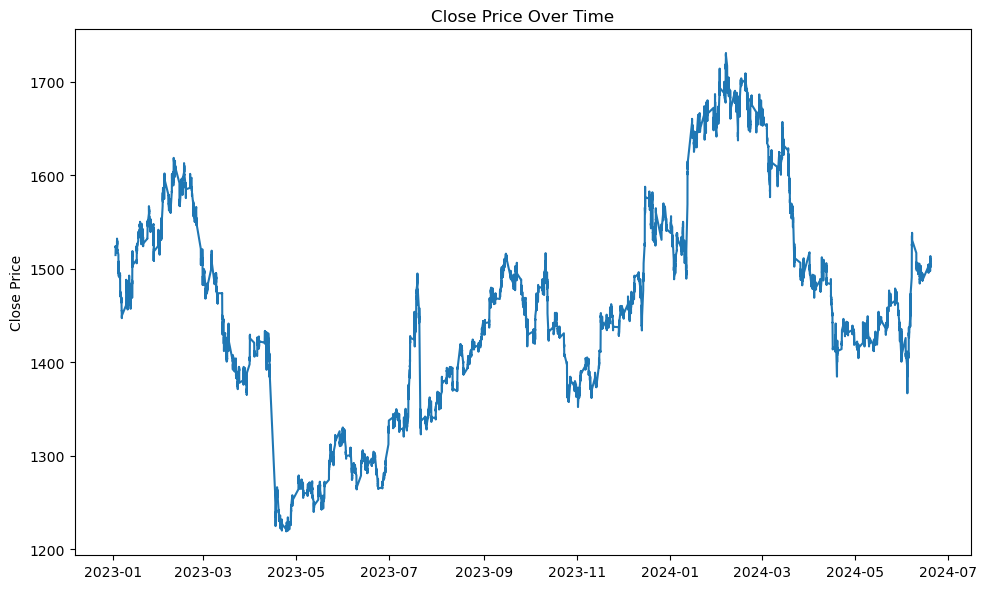

In [43]:
plt.figure(figsize=(10, 6)) 
plt.plot(backtest_df['Close'])
plt.ylabel('Close Price')
plt.title('Close Price Over Time')
plt.tight_layout()
plt.show()


# Computing the daily returns

In [44]:
backtest_df['Return'] = backtest_df['Close'] / backtest_df['Close'].shift(1)
backtest_df['Return'].iat[0] = 1 
backtest_df['Bench_Bal'] = starting_balance*backtest_df['Return'].cumprod()
backtest_df.head()

,Open,High,Low,Close,Volume,MACD,MACD_SIGNAL,macd_histogram,RSI,Signal,Return,Bench_Bal
date,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,0.768204,0.722998,0.045206,60.243941,0,1.000000,10000.000000
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,0.812316,0.740862,0.071455,61.656418,0,1.000330,10003.300984
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,0.825654,0.757820,0.067834,60.956728,0,0.999901,10002.310689
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,0.974274,0.801111,0.173163,66.070792,0,1.001221,10014.524328
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1.087588,0.858406,0.229181,66.327541,0,1.000066,10015.184525


# Visualising the macd and rsi 

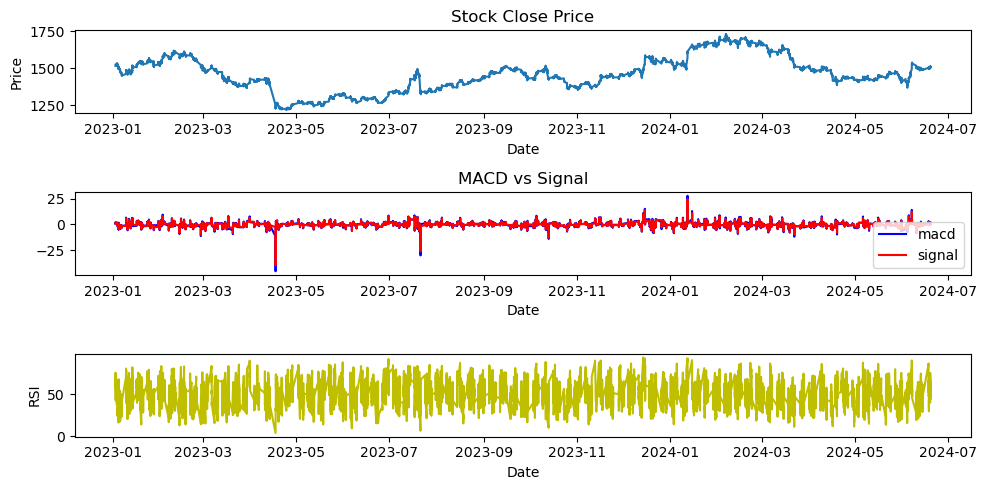

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(311)
plt.plot(backtest_df['Close'])
plt.title('Stock Close Price')  
plt.ylabel('Price')             
plt.xlabel('Date')

plt.subplot(312)
plt.plot(backtest_df['MACD'],c='b',)
plt.plot(backtest_df['MACD_SIGNAL'],c='r')
plt.title('MACD vs Signal')  
plt.legend(['macd','signal'])             
plt.xlabel('Date')

plt.subplot(313)
plt.plot(backtest_df['RSI'],c='y')
plt.xlabel('Date')
plt.ylabel('RSI')

plt.tight_layout()

# Computing the draw down balance 

In [46]:
backtest_df['Bench_Peak'] = backtest_df['Bench_Bal'].cummax()
backtest_df['Bench_DD'] = backtest_df['Bench_Bal'] - backtest_df['Bench_Peak']
bench_dd = round((backtest_df['Bench_DD'] / backtest_df['Bench_Peak']).min()*100,2)
bench_dd

-24.67

In [47]:
backtest_df['Long'] = ((backtest_df['MACD'] > backtest_df['MACD_SIGNAL']) & (backtest_df['RSI'] < 30))
backtest_df.head() 

,Open,High,Low,Close,Volume,MACD,MACD_SIGNAL,macd_histogram,RSI,Signal,Return,Bench_Bal,Bench_Peak,Bench_DD,Long
date,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,0.768204,0.722998,0.045206,60.243941,0,1.000000,10000.000000,10000.000000,0.000000,False
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,0.812316,0.740862,0.071455,61.656418,0,1.000330,10003.300984,10003.300984,0.000000,False
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,0.825654,0.757820,0.067834,60.956728,0,0.999901,10002.310689,10003.300984,-0.990295,False
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,0.974274,0.801111,0.173163,66.070792,0,1.001221,10014.524328,10014.524328,0.000000,False
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1.087588,0.858406,0.229181,66.327541,0,1.000066,10015.184525,10015.184525,0.000000,False


In [48]:
backtest_df['Sys_Ret'] = np.where(backtest_df['Long'].shift(1) == True, backtest_df['Return'], 1)

backtest_df['Sys_Bal'] = starting_balance * backtest_df['Sys_Ret'].cumprod()

backtest_df


,Open,High,Low,Close,Volume,MACD,MACD_SIGNAL,macd_histogram,RSI,Signal,Return,Bench_Bal,Bench_Peak,Bench_DD,Long,Sys_Ret,Sys_Bal
date,,,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,0.768204,0.722998,0.045206,60.243941,0,1.000000,10000.000000,10000.000000,0.000000,False,1.0,10000.000000
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,0.812316,0.740862,0.071455,61.656418,0,1.000330,10003.300984,10003.300984,0.000000,False,1.0,10000.000000
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,0.825654,0.757820,0.067834,60.956728,0,0.999901,10002.310689,10003.300984,-0.990295,False,1.0,10000.000000
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,0.974274,0.801111,0.173163,66.070792,0,1.001221,10014.524328,10014.524328,0.000000,False,1.0,10000.000000
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1.087588,0.858406,0.229181,66.327541,0,1.000066,10015.184525,10015.184525,0.000000,False,1.0,10000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1.109390,0.859782,0.249608,58.594998,0,0.999868,9984.485377,11424.374464,-1439.889087,False,1.0,9764.526763
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1.067534,0.901332,0.166202,56.727951,0,0.999736,9981.844590,11424.374464,-1442.529874,False,1.0,9764.526763
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1.026564,0.926378,0.100185,56.912767,0,1.000033,9982.174688,11424.374464,-1442.199776,False,1.0,9764.526763


In [49]:
backtest_df['Sys_Peak'] = backtest_df['Sys_Bal'].cummax()
backtest_df['Sys_DD'] = backtest_df['Sys_Bal'] - backtest_df['Sys_Peak']
sys_dd = round((backtest_df['Sys_DD'] / backtest_df['Sys_Peak'] ).min() * 100, 2)
sys_dd

-2.69

In [50]:
bench_return = round(((backtest_df.Bench_Bal.iloc[-1] / backtest_df.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((backtest_df.Bench_Bal.iloc[-1] / backtest_df.Bench_Bal.iloc[0]) ** (1 / 1.65)) - 1) * 100), 2)
sys_ret = round(((backtest_df.Sys_Bal.iloc[-1] / backtest_df.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((backtest_df.Sys_Bal.iloc[-1] / backtest_df.Sys_Bal.iloc[0]) ** (1 / 1.65)) - 1) * 100), 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}%')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_ret}%')
print(f'System CAGR: {sys_cagr}%')
print(f'System DD: {sys_dd}%')


Benchmark Total return: -0.29%
Benchmark CAGR: -0.18%
Benchmark DD: -24.67%

System Total return: -2.35%
System CAGR: -1.43%
System DD: -2.69%


In [51]:
copy_df

,open,high,low,close,volume,fast_ma,slow_ma,macd,signal,macd_histogram,close_diff,gain,loss,avg_gain,avg_loss,rs,rsi
date,,,,,,,,,,,,,,,,,
2023-01-02 12:00:00+05:30,1514.25,1515.50,1514.00,1514.70,17112,1513.933687,1513.165483,0.768204,0.722998,0.045206,0.70,0.70,0.00,0.629001,0.415089,1.515340,60.243941
2023-01-02 12:05:00+05:30,1514.70,1515.75,1514.00,1515.20,15477,1514.128505,1513.316188,0.812316,0.740862,0.071455,0.50,0.50,0.00,0.619787,0.385440,1.607998,61.656418
2023-01-02 12:10:00+05:30,1514.75,1515.70,1514.50,1515.05,12867,1514.270273,1513.444619,0.825654,0.757820,0.067834,-0.15,0.00,0.15,0.575516,0.368623,1.561261,60.956728
2023-01-02 12:15:00+05:30,1515.05,1517.00,1515.05,1516.90,21811,1514.674846,1513.700573,0.974274,0.801111,0.173163,1.85,1.85,0.00,0.666551,0.342293,1.947313,66.070792
2023-01-02 12:20:00+05:30,1516.90,1517.65,1516.15,1517.00,26795,1515.032562,1513.944975,1.087588,0.858406,0.229181,0.10,0.10,0.00,0.626083,0.317843,1.969786,66.327541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19 15:05:00+05:30,1512.30,1513.00,1510.00,1512.35,208296,1511.444548,1510.335158,1.109390,0.859782,0.249608,-0.20,0.00,0.20,0.547796,0.387089,1.415167,58.594998
2024-06-19 15:10:00+05:30,1512.00,1512.15,1510.05,1511.95,135352,1511.522310,1510.454776,1.067534,0.901332,0.166202,-0.40,0.00,0.40,0.508668,0.388012,1.310961,56.727951
2024-06-19 15:15:00+05:30,1511.95,1512.50,1511.00,1512.00,187745,1511.595801,1510.569237,1.026564,0.926378,0.100185,0.05,0.05,0.00,0.475906,0.360296,1.320873,56.912767


# Checking the current trend 

In [52]:
def check_trend(trend_dir,ticker,df):
    if (df['macd'].iloc[-1] > df['signal'].iloc[-1]) and (df['rsi'].iloc[-1] < 30):
        trend_dir[ticker] = "bullish"
    if (df['macd'].iloc[-1] < df['signal'].iloc[-1]) and (df['rsi'].iloc[-1] > 70):
        trend_dir[ticker] = "bearish"
    return trend_dir

In [53]:
trend_dir = {}
ticker = "INFY"
trend_dir[ticker] = [None]
trend_dir = check_trend(trend_dir,ticker,copy_df)
print(trend_dir)

{'INFY': [None]}


# Notifies us if a stock is bought or sold or approaching the stop loss   

In [54]:
email = open('gmail.txt','r').read().split('\n')[0]
password = open('gmail.txt','r').read().split('\n')[1]
app_password = open('gmail.txt','r').read().split('\n')[2]

In [55]:
def send_email_notification(email,app_password,stock_name, quantity, price):
    sender_email = email
    sender_password = app_password
    receiver_email = email
    subject = f"Order Placed: {stock_name}"
    body = f"Stock: {stock_name}\nQuantity: {quantity}\nPrice: {price}"

    # Create the email message
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        # Send the email using Gmail's SMTP server
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()  # Secure the connection
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
        print(f"Email sent to {receiver_email} regarding the order of {stock_name}.")
    except Exception as e:
        print(f"Failed to send email: {e}")


# Creating a place order function 

In [56]:
def placeOrderWithStopAndTarget(symbol, buy_sell, quantity, sl_price, target_price,email, app_password):    
    """
    Places an intraday order with stop loss and target profit on NSE.
    
    :param symbol: The trading symbol of the asset.
    :param buy_sell: 'buy' or 'sell' indicating the initial trade direction.
    :param quantity: The number of shares/contracts to trade.
    :param sl_price: The stop loss price.
    :param target_price: The target profit price.
    """
    if buy_sell == "buy":
        t_type = kite.TRANSACTION_TYPE_BUY
        t_type_sl = kite.TRANSACTION_TYPE_SELL
    elif buy_sell == "sell":
        t_type = kite.TRANSACTION_TYPE_SELL
        t_type_sl = kite.TRANSACTION_TYPE_BUY
    
    # Place the initial market order
    market_order = kite.place_order(
        tradingsymbol=symbol,
        exchange=kite.EXCHANGE_NSE,
        transaction_type=t_type,
        quantity=quantity,
        order_type=kite.ORDER_TYPE_MARKET,
        product=kite.PRODUCT_CNC,
        variety=kite.VARIETY_REGULAR
    )

    a = 0
    while a < 10:
        try:
            order_list = kite.orders()
            break
        except:
            print("Can't get orders..retrying")
            a += 1
            time.sleep(1)  # Adding a delay to avoid rapid retries

    for order in order_list:
        if order["order_id"] == market_order:
            if order["status"] == "COMPLETE":
                last_price = kite.ltp([kite.EXCHANGE_NSE + ":" + symbol])[kite.EXCHANGE_NSE + ":" + symbol]['last_price']
                
                # Send email notification for the market order
                send_email_notification(email, app_password, symbol, quantity, last_price)

                # Place stop loss order
                kite.place_order(
                    tradingsymbol=symbol,
                    exchange=kite.EXCHANGE_NSE,
                    transaction_type=t_type_sl,
                    quantity=quantity,
                    order_type=kite.ORDER_TYPE_SL,
                    price=sl_price,
                    trigger_price=sl_price,
                    product=kite.PRODUCT_CNC,
                    variety=kite.VARIETY_REGULAR
                )
                # Place target profit order
                kite.place_order(
                    tradingsymbol=symbol,
                    exchange=kite.EXCHANGE_NSE,
                    transaction_type=t_type_sl,
                    quantity=quantity,
                    order_type=kite.ORDER_TYPE_LIMIT,
                    price=target_price,  # Target profit level
                    product=kite.PRODUCT_CNC,
                    variety=kite.VARIETY_REGULAR
                )
            else:
                # If the market order isn't completed, cancel it
                kite.cancel_order(order_id=market_order, variety=kite.VARIETY_REGULAR)
                print(f"Order {market_order} was not completed and has been cancelled.")


In [57]:
def monitor_stop_loss_proximity(symbol, sl_price, email, app_password):
    """
    Monitors the market price and sends an email if it nears the stop loss price.
    :param symbol: The trading symbol of the asset.
    :param sl_price: The stop loss price.
    :param email: Email address for sending notifications.
    :param app_password: App password for the email account.
    """
    threshold = 0.05  # Define how close to the stop loss should trigger the email (e.g., 5%)
    
    while True:
        try:
            # Get the latest price
            ltp = kite.ltp([kite.EXCHANGE_NSE + ":" + symbol])[kite.EXCHANGE_NSE + ":" + symbol]['last_price']
            print(f"Current LTP: {ltp}, Stop Loss Price: {sl_price}")

            if ltp <= sl_price * (1 + threshold):  # If the price is within the threshold of the stop loss
                send_email_notification(
                    email, 
                    app_password, 
                    f"Stock nearing stop loss: {symbol}", 
                    f"Price is nearing the stop loss of {sl_price}", 
                    ltp
                )
                print(f"Email sent for {symbol} nearing stop loss.")
                break  # Exit the loop after sending the notification

        except Exception as e:
            print(f"Error while monitoring price: {e}")

        time.sleep(60)  # Check the price every minute (adjust as needed)


# Modify the order according to the trailing loss

In [58]:
def ModifyOrder(order_id,price):    
    # Modify order given order id
    kite.modify_order(order_id=order_id,
                    price=price,
                    trigger_price=price,
                    order_type=kite.ORDER_TYPE_SL,
                    variety=kite.VARIETY_REGULAR)      

# Strategy implementation

In [88]:
tickers = ["ZEEL","WIPRO","VEDL","ULTRACEMCO","UPL","TITAN","TECHM","TATASTEEL",
           "TATAMOTORS","TCS","SUNPHARMA","SBIN","SHREECEM","RELIANCE","POWERGRID",
           "ONGC","NESTLEIND","NTPC","MARUTI","M&M","LT","KOTAKBANK","JSWSTEEL","INFY",
           "INDUSINDBK","IOC","ITC","ICICIBANK","HDFC","HINDUNILVR","HINDALCO",
           "HEROMOTOCO","HDFCBANK","HCLTECH","GRASIM","GAIL","EICHERMOT","DRREDDY",
           "COALINDIA","CIPLA","BRITANNIA","BHARTIARTL","BPCL","BAJAJFINSV",
           "BAJFINANCE","BAJAJ-AUTO","AXISBANK","ASIANPAINT","ADANIPORTS"]


In [59]:
def main(capital, email, app_password):
    trend_dir = {}
    a, b = 0, 0
    while a < 10:
        try:
            pos_df = pd.DataFrame(kite.positions()["day"])
            break
        except:
            print("Can't extract position data..retrying")
            a += 1
    while b < 10:
        try:
            ord_df = pd.DataFrame(kite.orders())
            break
        except:
            print("Can't extract order data..retrying")
            b += 1
    
    for ticker in tickers:
        print("Starting passthrough for.....", ticker)
        try:
            ohlc = fetchOHLC(ticker, "5minute", 4)
            ohlc = compute_ema(ohlc, 12, 'fast_ma')
            ohlc = compute_ema(ohlc, 26, 'slow_ma')
            ohlc['macd'] = ohlc['fast_ma'] - ohlc['slow_ma']
            ohlc = compute_signal(ohlc, 9)
            ohlc['macd_histogram'] = ohlc['macd'] - ohlc['signal']
            ohlc = compute_rsi(ohlc, 14)

            trend_dir = check_trend(trend_dir, ticker, ohlc)
            quantity = int(capital / ohlc["close"].iloc[-1])
            
            # Compute stop loss and target profit based on 1:2 risk-to-reward ratio
            stop_loss, target_profit = compute_targets(ohlc, risk_ratio=1, reward_ratio=2)

            if len(pos_df.columns) == 0:
                if trend_dir[ticker] == "bullish":
                    placeOrderWithStopAndTarget(ticker, "buy", quantity, stop_loss, target_profit, email, app_password)
                    monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
                if trend_dir[ticker] == "bearish":
                    placeOrderWithStopAndTarget(ticker, "sell", quantity, stop_loss, target_profit, email, app_password)
                    monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
            if len(pos_df.columns) != 0 and ticker not in pos_df["tradingsymbol"].tolist():
                if trend_dir[ticker] == "bullish":
                    placeOrderWithStopAndTarget(ticker, "buy", quantity, stop_loss, target_profit, email, app_password)
                    monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
                if trend_dir[ticker] == "bearish":
                    placeOrderWithStopAndTarget(ticker, "sell", quantity, stop_loss, target_profit, email, app_password)
                    monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
            if len(pos_df.columns) != 0 and ticker in pos_df["tradingsymbol"].tolist():
                if pos_df[pos_df["tradingsymbol"] == ticker]["quantity"].values[0] == 0:
                    if trend_dir[ticker] == "bullish":
                        placeOrderWithStopAndTarget(ticker, "buy", quantity, stop_loss, target_profit, email, app_password)
                        monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
                    if trend_dir[ticker] == "bearish":
                        placeOrderWithStopAndTarget(ticker, "sell", quantity, stop_loss, target_profit, email, app_password)
                        monitor_stop_loss_proximity(ticker, stop_loss, email, app_password)
                if pos_df[pos_df["tradingsymbol"] == ticker]["quantity"].values[0] != 0:
                    order_id = ord_df.loc[(ord_df['tradingsymbol'] == ticker) & (ord_df['status'].isin(["TRIGGER PENDING", "OPEN"]))]["order_id"].values[0]
                    ModifyOrder(order_id, stop_loss)
        except Exception as e:
            print(f"API error for ticker {ticker}: {e}")

In [ ]:
#create KiteTicker object
kws = KiteTicker(key_secret[0],kite.access_token)
tokens = tokenLookup(instrument_df,tickers)

start_minute = dt.datetime.now().minute
def on_ticks(ws,ticks):
    global start_minute
    renkoOperation(ticks)
    now_minute = dt.datetime.now().minute
    if abs(now_minute - start_minute) >= 5:
        start_minute = now_minute
        main(capital)

def on_connect(ws,response):
    ws.subscribe(tokens)
    ws.set_mode(ws.MODE_LTP,tokens)

while True:
    now = dt.datetime.now()
    if (now.hour >= 9):
        kws.on_ticks=on_ticks
        kws.on_connect=on_connect
        kws.connect()
    if (now.hour >= 14 and now.minute >= 30):
        sys.exit()

In [60]:
# copy_df.to_csv('backtest.csv')

In [61]:
# backtest_df = copy_df.copy()

In [62]:
# backtest_df.columns

In [63]:
# backtest_df.drop(['fast_ma', 'slow_ma', 'close_diff', 'gain', 'loss', 'avg_gain',
#        'avg_loss', 'rs'],axis=1,inplace=True)

In [64]:
# backtest_df = backtest_df.rename(columns={
#     'open': 'Open',
#     'high': 'High',
#     'low': 'Low',
#     'close': 'Close',
#     'volume': 'Volume',
#     'macd': 'MACD',
#     'signal': 'SIGNAL',
#     'macd_histogram': 'MACD_HIST',
#     'rsi': 'RSI'
# })


In [65]:
# backtest_df.columns

In [66]:
# backtest_df

In [67]:
# class MacdRsi(Strategy):
#     stop_loss = 0.05  
#     take_profit = 0.1

#     def init(self):
#         pass
    
#     def next(self):
#         # Access precomputed RSI, MACD, and MACD_signal
#         rsi = self.data.RSI[-1]
#         macd = self.data.MACD[-1]
#         macd_signal = self.data.SIGNAL[-1]

#         # Buy Signal: RSI < 30 and MACD > MACD_signal
#         if rsi < 30 and macd > macd_signal:
#             self.buy(sl=self.data.Close[-1] * (1 - self.stop_loss),
#                      tp=self.data.Close[-1] * (1 + self.take_profit))
        
#         # Sell Signal: RSI > 70 and MACD_signal > MACD
#         elif rsi > 70 and macd_signal > macd:
#             self.sell(sl=self.data.Close[-1] * (1 + self.stop_loss),
#                       tp=self.data.Close[-1] * (1 - self.take_profit))


In [68]:
# backtest_df_resampled = backtest_df.resample('D').agg({
#     'Open': 'first',
#     'High': 'max',
#     'Low': 'min',
#     'Close': 'last',
#     'Volume': 'sum',
#     'RSI': 'last',
#     'MACD': 'last',
#     'SIGNAL': 'last'
# }).dropna()


In [69]:
# bt = Backtest(backtest_df, MacdRsi, cash=10000, commission=.002)
# stats = bt.run()
# bt.plot()

# # Display backtest statistics
# print(stats)


In [70]:
# print("Checking column lengths:")
# for column in backtest_df.columns:
#     print(f"{column}: {len(backtest_df[column])}")

# # Ensure that all columns have the same number of entries
# print("\nChecking for missing values:")
# print(backtest_df.isna().sum())

# print("\nDataFrame columns:")
# print(backtest_df.columns)

# print("\nDataFrame head:")
# print(backtest_df.head())


# Trend directions

In [71]:
# def check_trend(df):
#     df['trend'] = np.NaN
#     for i in range(len(df)):
#         # Check for bullish trend
#         if (df['macd'].iloc[i] > df['signal'].iloc[i]) and (df['rsi'].iloc[i] < 30):
#             df.loc[df.index[i], 'trend'] = "bullish"
#         # Check for bearish trend
#         elif (df['macd'].iloc[i] < df['signal'].iloc[i]) and (df['rsi'].iloc[i] > 70):
#             df.loc[df.index[i], 'trend'] = "bearish"
#     return df

In [72]:
# new_df = copy_df.copy()

In [73]:
# new_df = check_trend(new_df)
# new_df


In [74]:
# print('bearish',len(new_df[new_df['trend'] == 'bearish']))
# print('bullish',len(new_df[new_df['trend'] == 'bullish']))


In [75]:
# new_df.to_csv('trends.csv')

In [76]:
# new_df.dropna(inplace=True)

In [77]:
# new_df

# Placing Buy and Sell orders

In [78]:
# def placeSLOrder(symbol,buy_sell,quantity,sl_price,take_profit):    
#     # Place an intraday stop loss order on NSE - handles market orders converted to limit orders
#     if buy_sell == "buy":
#         t_type = kite.TRANSACTION_TYPE_BUY
#         t_type_sl = kite.TRANSACTION_TYPE_SELL
#         t_type_target = kite.TRANSACTION_TYPE_SELL

#     elif buy_sell == "sell":
#         t_type=kite.TRANSACTION_TYPE_SELL
#         t_type_sl=kite.TRANSACTION_TYPE_BUY

#     market_order = kite.place_order(tradingsymbol=symbol,
#                     exchange=kite.EXCHANGE_NSE,
#                     transaction_type=t_type,
#                     quantity=quantity,
#                     order_type=kite.ORDER_TYPE_MARKET,
#                     product=kite.PRODUCT_CNC,
#                     variety=kite.VARIETY_REGULAR)
    
#     target_order = kite.place_order(tradingsymbol=symbol,
#                  exchange=kite.EXCHANGE_NSE,
#                  transaction_type=t_type_target,
#                  quantity=quantity,
#                  order_type=kite.ORDER_TYPE_LIMIT,
#                  price=take_profit,  # Define this as your take-profit price
#                  product=kite.PRODUCT_CNC,
#                  variety=kite.VARIETY_REGULAR)

#     a = 0
#     while a < 10:
#         try:
#             order_list = kite.orders()
#             break
#         except:
#             print("can't get orders..retrying")
#             a+=1
#     for order in order_list:
#         if order["order_id"]==market_order:
#             if order["status"]=="COMPLETE":
#                 kite.place_order(tradingsymbol=symbol,
#                                 exchange=kite.EXCHANGE_NSE,
#                                 transaction_type=t_type_sl,
#                                 quantity=quantity,
#                                 order_type=kite.ORDER_TYPE_SL,
#                                 price=sl_price,
#                                 trigger_price = sl_price,
#                                 product=kite.PRODUCT_CNC,
#                                 variety=kite.VARIETY_REGULAR)
#             else:
#                 kite.cancel_order(order_id=market_order,variety=kite.VARIETY_REGULAR)

In [79]:
# def generate_signals(df):
#     df = df.copy()
#     buy_signals = []
#     sell_signals = []
#     for i in range(len(df)):
#         if df['trend'].iloc[i] == 'bullish':
#             buy_signals.append(df['close'].iloc[i])
#             sell_signals.append(np.nan)
#         elif df['trend'].iloc[i] == 'bearish':
#             buy_signals.append(np.nan)
#             sell_signals.append(df['close'].iloc[i])
#         else:
#             buy_signals.append(np.nan)
#             sell_signals.append(np.nan)
#     df['buy_signal'] = buy_signals
#     df['sell_signal'] = sell_signals
#     return df

In [80]:
# signals_df = generate_signals(new_df) 

In [81]:
# len(signals_df['buy_signal']),len(signals_df['sell_signal'])

In [82]:
# buy_sell_df = signals_df.copy()

In [83]:
#buy_sell_df.dropna(inplace=True)

In [84]:
# buy_sell_df.fillna(0,inplace=True)

In [85]:
# print(buy_sell_df['buy_signal'].isna().value_counts())

In [86]:
# buy_sell_df.to_csv('buy_sell.csv')

In [87]:
# buy_sell_df